# SALARY PREDICTION

In [506]:
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from helpers.data_prep import *
from helpers.eda import *
from sklearn.model_selection import train_test_split, GridSearchCV

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## Some functions to be used in the rest of the project

In [507]:
# This function allows us to see the RMSE values of other algorithms
def all_models(X, y, test_size=0.2, random_state=1):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)
    all_models = []

    models = [('LR', LinearRegression()),
              ("Ridge", Ridge()),
              ("Lasso", Lasso()),
              ("ElasticNet", ElasticNet()),
              ('KNN', KNeighborsRegressor()),
              ('CART', DecisionTreeRegressor()),
              ('RF', RandomForestRegressor()),
              ('SVR', SVR()),
              ('GBM', GradientBoostingRegressor()),
              ("XGBoost", XGBRegressor()),
              ("LightGBM", LGBMRegressor()),
              ("CatBoost", CatBoostRegressor(verbose=False))]

    for name, model in models:
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        values = dict(name=name, RMSE_TRAIN=rmse_train, RMSE_TEST=rmse_test)
        all_models.append(values)

    all_models_df = pd.DataFrame(all_models)
    all_models_df = all_models_df.sort_values(all_models_df.columns[2], ascending=True)
    return all_models_df

In [508]:
# This function visualizes the importance of features
def plot_importance(model, features, save=False):

    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:len(features)])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

## Examining data with helper functions in the helpers folder

In [509]:
df = load_csv("hitters.csv")
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N


In [510]:
check_df(df)

##################### Shape #####################
(322, 20)
##################### Types #####################
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
##################### Head #####################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        

In [511]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


In [512]:
for cat in cat_cols:
    cat_summary(df,cat)
    target_summary_with_cat(df,"Salary",cat)

   League  Ratio
A     175 54.348
N     147 45.652
##########################################
        TARGET_MEAN
League             
A           542.000
N           529.118


   Division  Ratio
W       165 51.242
E       157 48.758
##########################################
          TARGET_MEAN
Division             
E             624.271
W             450.877


   NewLeague  Ratio
A        176 54.658
N        146 45.342
##########################################
           TARGET_MEAN
NewLeague             
A              537.113
N              534.554




In [513]:
for num in num_cols:
    if num != "Salary":
        num_summary(df,num)
        target_summary_with_num(df,"Salary",num)

count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
20%     221.800
30%     281.300
40%     321.800
50%     379.500
60%     430.200
70%     490.000
80%     535.600
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64

           AtBat
Salary          
67.500   181.000
68.000   209.000
70.000   248.600
75.000   236.400
80.000   399.000
...          ...
1940.000 514.000
1975.000 677.000
2127.333  20.000
2412.500 618.000
2460.000 495.000

[150 rows x 1 columns]


count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
20%      57.000
30%      70.000
40%      82.000
50%      96.000
60%     113.000
70%     128.700
80%     144.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64

            Hits
Salary          
67.500    41.000
68.000    54.000
70.000    57.400
75.000    58.200
80.000   102.000
...          ...
1940.000 144.000

## Correlation analysis

In [514]:
high_correlated_cols(df)

['Hits', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks']

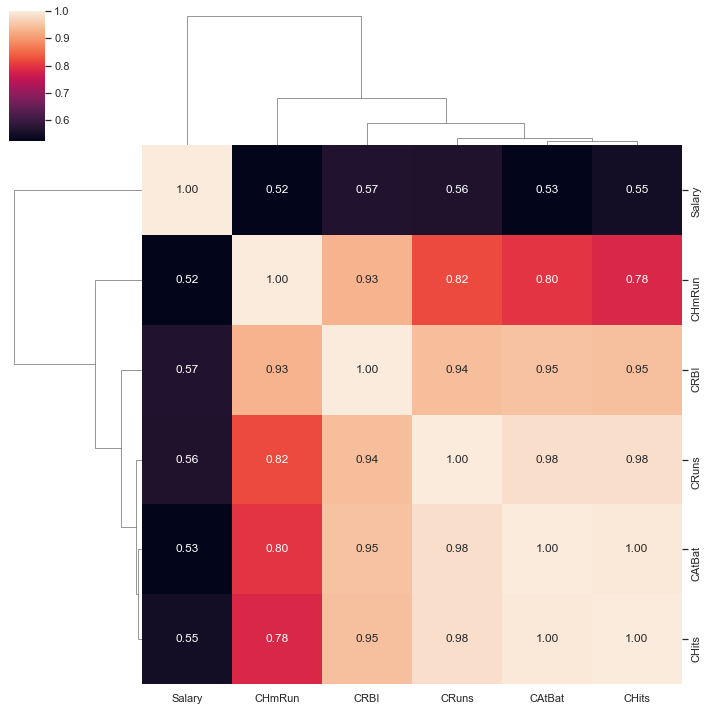

['CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'Salary']

In [515]:
target_correlation_matrix(df)

## Outlier analysis

In [516]:
for col in num_cols:
    print(col,check_outlier(df,col,0.1,0.90))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits True
CHmRun True
CRuns False
CRBI False
CWalks True
PutOuts False
Assists False
Errors False
Salary False


## Missing value analysis

In [517]:
missing_values_table(df)

        n_miss  ratio
Salary      59 18.320


## Encoding the categorical columns and deleting rows with missing values
###### Label encoder is used because categorical columns are in binary format

In [518]:
for col in cat_cols:
    label_encoder(df,col)

In [519]:
df_null = df[df["Salary"].isnull()]
df.dropna(inplace=True)

In [520]:
X = df.drop("Salary",axis=1)
y = df["Salary"]

## Analysing of RMSE values and choosing the algorithm

In [521]:
all_models(X,y)

,name,RMSE_TRAIN,RMSE_TEST
10,LightGBM,143.489,263.528
11,CatBoost,15.444,277.224
6,RF,117.889,295.403
8,GBM,58.410,320.757
9,XGBoost,0.018,344.320
2,Lasso,292.011,365.368
1,Ridge,291.997,365.492
0,LR,291.993,365.507
3,ElasticNet,294.855,367.246
4,KNN,255.177,370.357


In [522]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [523]:
lightGBM_model = LGBMRegressor(random_state=1).fit(X_train, y_train)

In [524]:
y_pred = lightGBM_model.predict(X_test)
print("LightGBM Model Train RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

LightGBM Model Train RMSE: 263.5279248633645


## Replace outliers with threshold values

In [525]:
for col in num_cols:
    replace_with_thresholds(df,col,0.1,0.90)
for col in num_cols:
    print(col,check_outlier(df,col,0.1,0.90))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False
Salary False


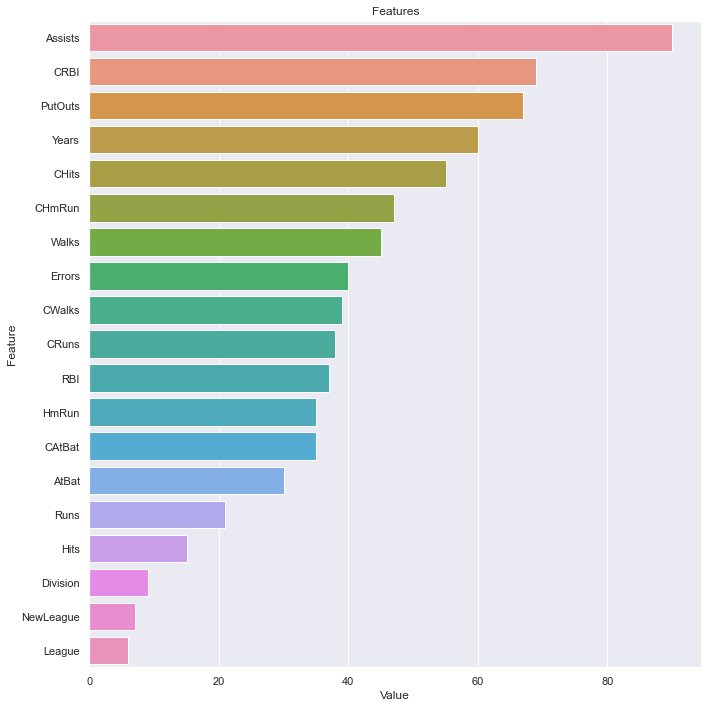

In [526]:
plot_importance(lightGBM_model,X)

In [527]:
df.columns = [col.upper() for col in df.columns]
df.head()

,ATBAT,HITS,HMRUN,RUNS,RBI,WALKS,YEARS,CATBAT,CHITS,CHMRUN,CRUNS,CRBI,CWALKS,LEAGUE,DIVISION,PUTOUTS,ASSISTS,ERRORS,SALARY,NEWLEAGUE
1,315.000,81,7.000,24,38.000,39.000,14,3449.000,835.000,69.000,321.000,414.000,375.000,1,1,632.000,43.000,10,475.000,1
2,479.000,130,18.000,66,72.000,76.000,3,1624.000,457.000,63.000,224.000,266.000,263.000,0,1,880.000,82.000,14,480.000,0
3,496.000,141,20.000,65,78.000,37.000,11,5628.000,1575.000,225.000,828.000,838.000,354.000,1,0,200.000,11.000,3,500.000,1
4,321.000,87,10.000,39,42.000,30.000,2,396.000,101.000,12.000,48.000,46.000,33.000,1,0,805.000,40.000,4,91.500,1
5,594.000,169,4.000,74,51.000,35.000,11,4408.000,1133.000,19.000,501.000,336.000,194.000,0,1,282.000,421.000,25,750.000,0


## Creating new features from existing columns

In [528]:
df["NEW_HITRATIO"] = df["HITS"]/df["ATBAT"]
df["NEW_CHITRATIO"] = df["CHITS"] / df["CATBAT"]

df["NEW_HIT"] = df["HITS"] / df["CHITS"]
df["NEW_ATBAR"] = df["ATBAT"] / df["CATBAT"]
df["NEW_RUN"] = df["RUNS"] / df["CRUNS"]
df["NEW_CHMRUN"] = df["HMRUN"] / (df["CHMRUN"]+1)
df["NEW_RBI"] = df["RBI"] / df["CRBI"]
df["NEW_WALK"] = df["WALKS"] / df["CWALKS"]

df["NEW_ERRORRATIO"] = df["ERRORS"] / df["ATBAT"]
df["NEW_RUNRATIO"] = df["HMRUN"] / (df["RUNS"]+1)
df["NEW_CRUNRATIO"] = df["CHMRUN"] / df["CRUNS"]

df["NEW_AVG_ATBAT"] = df["CATBAT"] / df["YEARS"]
df["NEW_AVG_HITS"] = df["CHITS"] / df["YEARS"]
df["NEW_AVG_HMRUNS"] = df["CHMRUN"] / df["YEARS"]
df["NEW_AVG_RUNS"] = df["CRUNS"] / df["YEARS"]
df["NEW_AVG_RBI"] = df["CRBI"] / df["YEARS"]
df["NEW_AVG_WALKS"] = df["CWALKS"] / df["YEARS"]

df["NEW_ASSISTPUTOUTS"] = df["ASSISTS"] * df["PUTOUTS"]
df["NEW_RUNS"] = df["HMRUN"] * df["RUNS"]
df["NEW_HITRUNS"] = df["HITS"] * df["RUNS"]

In [529]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 263
Variables: 40
cat_cols: 3
num_cols: 37
cat_but_car: 0
num_but_cat: 3


## Scaling num_cols with using StandardScaler

In [530]:
num_cols.remove("SALARY")
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [531]:
X = df.drop("SALARY",axis=1)
y = df["SALARY"]

In [532]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Finding the best parameters

In [533]:
lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "max_depth": [3, 8, 10],
                   "n_estimators": [50, 100, 500, 1000],
                   "colsample_bytree": [1, 0.25, 0.5, 0.7]}

In [534]:
lightgbm_best_grid = GridSearchCV(lightGBM_model, lightgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
lightgbm_best_grid.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


{'colsample_bytree': 0.25,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100}

In [535]:
lightgbm_final = lightGBM_model.set_params(**lightgbm_best_grid.best_params_, random_state=1).fit(X, y)

## Testing final model

In [536]:
y_pred = lightgbm_final.predict(X_test)
print("LGBM Final Model Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

LGBM Final Model Test RMSE: 146.7808065719314


In [537]:
y_pred_train = lightgbm_final.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_train

144.61845701510074

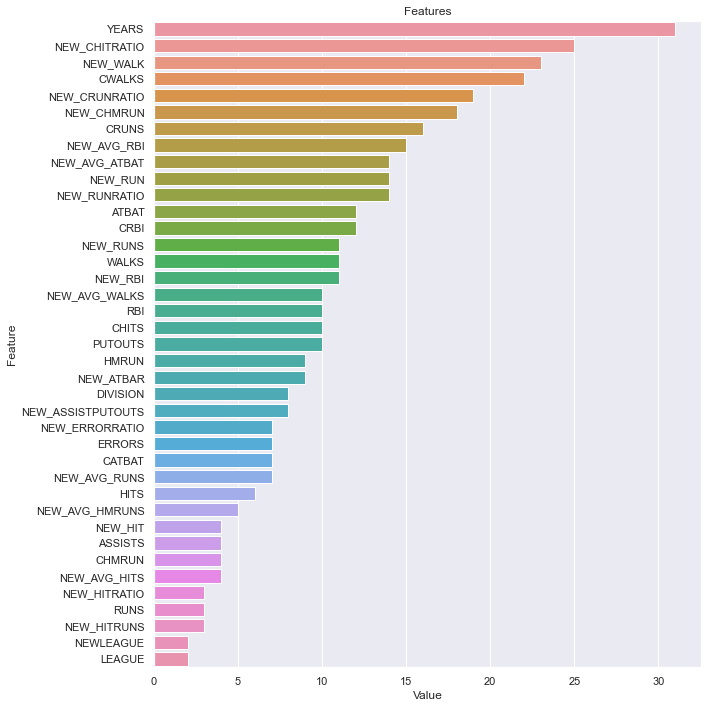

In [538]:
plot_importance(lightgbm_final,X)

## Saving the model

In [539]:
import pickle
pickle.dump(lightgbm_final, open("lightgbm_final_model.pkl", 'wb'))